# Recyclable and Household Waste Classification with EfficientNetV2
1. Base Model : EfficientNetV2
  - Paper : [EfficientNetV2: Smaller Models and Faster Training](https://arxiv.org/pdf/2104.00298)
2. 성능 개선 시도
  - EfficientNetV2-S Pretrained Weights
    - 사전 학습된 ```EfficientNetV2-S```는 ImageNet-1K 데이터셋에서 학습된 가중치를 사용하여 초기화
    - 사전 학습된 Layer는 동결 후 추가적인 레이어에 대해서만 학습 진행
  - Attention Mechanism
    - Attention Mechanism 클래스 정의: 입력 특징에서 context vector를 생성하고, 각 특징의 중요도를 Softmax를 통해 학습
    - 각 시퀀스 위치의 중요도를 모델이 학습하여 특징 정보에 대한 context를 강조함으로써 성능 향상을 도모
    - SE(Squeeze-and-Excitation)와 달리 입력 시퀀스의 공간적 중요도를 강조
  - 모델 구조 개선
    - EfficientNetV2의 feature extractor 후 Attention Mechanism을 추가
    - Attention 모듈로부터 생성된 context vector를 추가적인 Fully Connected Layer와 GELU 활성화를 통해 비선형 변환
    - 최종적으로 Dropout을 적용하여 과적합 방지
    - 최종적으로 GPU 상에서 Inference 속도가 약 **5배** 가량 개선됨
3. 성능 개선 결과 (on A100)
  - Accuracy
    - `EfficientNetV2` (base) : 86.40%
    - `EfficientNetV2+Attention` : 83.83%
  - **Inference Time** **(1.98 times faster at CPU, 5.03 times faster at GPU)**
    - `EfficientNetV2` : 5033ms(@CPU), 1586ms(@GPU)
    - `EfficientNetV2+Attention` : 2536ms(@CPU), 315.158ms(@GPU)

## 1. Import Libraries, Configuration, Dataset Load

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import efficientnet_v2_s
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import numpy as np
import torchvision

import warnings
warnings.filterwarnings('ignore')

In [3]:
%cd /content/drive/MyDrive/SWE3052
sys.path.append('/content/drive/MyDrive/SWE3052')

/content/drive/MyDrive/SWE3052


In [4]:
# configs 정의

CONFIGS = {
    # dataloader
    "num_workers": 2,
    "batch_size": 16,

    # train params
    "img_size": 256,
    "num_epochs": 100,
    "learning_rate": 0.001,
    "data_aug": True
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
# random seed 고정 함수
def set_seed():
  random.seed(17)

In [6]:
# 데이터 전처리 클래스
class WasteDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in ['default', 'real_world']:
                subfolder_dir = os.path.join(class_dir, subfolder)
                image_names = os.listdir(subfolder_dir)
                random.shuffle(image_names)

                if split == 'train':
                    image_names = image_names[:int(0.6 * len(image_names))]
                elif split == 'val':
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
                else: #split == 'test':
                    image_names = image_names[int(0.8 * len(image_names)):]

                for image_name in image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))
                    self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
set_seed()  # for reproduction

if CONFIGS["data_aug"]:
  train_transform = transforms.Compose([
      transforms.RandomResizedCrop(CONFIGS["img_size"], scale=(0.3, 1.0)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=torch.tensor(IMAGENET_DEFAULT_MEAN), std=torch.tensor(IMAGENET_DEFAULT_STD))
  ])
else:
  train_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=torch.tensor(IMAGENET_DEFAULT_MEAN), std=torch.tensor(IMAGENET_DEFAULT_STD))
  ])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=torch.tensor(IMAGENET_DEFAULT_MEAN), std=torch.tensor(IMAGENET_DEFAULT_STD))
])

dataset_path = "./data/images/images"
train_dataset = WasteDataset(dataset_path, split='train', transform=train_transform) # 데이터 증강
val_dataset = WasteDataset(dataset_path, split='val', transform=valid_transform)
test_dataset = WasteDataset(dataset_path, split='test', transform=valid_transform)
train_dataloader = DataLoader(train_dataset, batch_size=CONFIGS["batch_size"], num_workers=CONFIGS["num_workers"], pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=CONFIGS["batch_size"], num_workers=CONFIGS["num_workers"], pin_memory=True, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=CONFIGS["batch_size"], num_workers=CONFIGS["num_workers"], pin_memory=True, shuffle=False)

print("* Number of classes :",len(train_dataset.classes), len(val_dataset.classes), len(test_dataset.classes))
print("* Dataset lengths :", len(train_dataset), len(val_dataset), len(test_dataset))
print()
print("* Image paths")
print([os.path.basename(x) for x in train_dataset.image_paths[:5]])
print([os.path.basename(x) for x in val_dataset.image_paths[:5]])
print([os.path.basename(x) for x in test_dataset.image_paths[:5]])
print()
print("* Train transform")
print(train_transform) # data augmentation
print("* Valid transform")
print(valid_transform)

* Number of classes : 30 30 30
* Dataset lengths : 9000 3000 3000

* Image paths
['Image_23.png', 'Image_87.png', 'Image_174.png', 'Image_96.png', 'Image_150.png']
['Image_86.png', 'Image_149.png', 'Image_199.png', 'Image_108.png', 'Image_21.png']
['Image_244.png', 'Image_218.png', 'Image_1.png', 'Image_32.png', 'Image_14.png']

* Train transform
Compose(
    RandomResizedCrop(size=(256, 256), scale=(0.3, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)
* Valid transform
Compose(
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


## 2. Model Implementation (EfficientNetV2+Attention)

### 2-1. Attention Mechanism

In [23]:
# Attention Mechanism
class AttentionMechanism(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentionMechanism, self).__init__()
        self.attention = nn.Linear(input_dim, hidden_dim)
        self.context_vector = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, features):
        # features: (batch_size, seq_len, input_dim)
        attention_weights = torch.tanh(self.attention(features))  # (batch_size, seq_len, hidden_dim)
        attention_weights = self.context_vector(attention_weights).squeeze(-1)  # (batch_size, seq_len)
        attention_weights = F.softmax(attention_weights, dim=1)  # (batch_size, seq_len)
        context_vector = torch.sum(features * attention_weights.unsqueeze(-1), dim=1)  # (batch_size, input_dim)
        return context_vector, attention_weights

### 2-2. EfficientNet with Attention

In [ ]:
class EfficientNetWithAttention(nn.Module):
    def __init__(self, base_model, num_classes):
        super(EfficientNetWithAttention, self).__init__()
        self.features = base_model.features
        self.attention = AttentionMechanism(input_dim=1280, hidden_dim=512)
        self.additional_layer = nn.Sequential(
            nn.Linear(1280, 1024),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.1)
        )
        self.classifier = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x, return_attention=False):
        features = self.features(x)
        features = features.mean([2, 3])
        features = features.unsqueeze(1)
        context_vector, attention_weights = self.attention(features)
        context_vector = self.dropout(context_vector)
        intermediate_output = self.additional_layer(context_vector)
        logits = self.classifier(intermediate_output)

        if return_attention:
            return logits, attention_weights  # Attention이 필요할 때만 튜플 반환
        return logits  # 기본적으로 logits만 반환

## 3. Train Loop

### 3-1. Model Definition and Count Trainable Parameters

In [24]:
# Pretrained EfficientNetV2 Backbone
base_model = efficientnet_v2_s(weights="EfficientNet_V2_S_Weights.IMAGENET1K_V1")

num_classes = 30
model = EfficientNetWithAttention(base_model, num_classes).to(device)

# EfficientNetV2 레이어 Freeze
for param in model.features.parameters():
    param.requires_grad = False

In [26]:
# 손실함수, 옵티마이저
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=CONFIGS["learning_rate"])

In [25]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Trainable Parameters in %: {round((trainable_params/total_params)*100, 2)}%")

# 모델 파라미터 개수 확인
count_parameters(model)

Total parameters: 22,685,806
Trainable parameters: 2,508,318
Trainable Parameters in %: 11.06%


### 3-2. Training Function

In [27]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # tqdm을 배치 루프에 적용
    train_bar = tqdm(train_loader, desc="Training", leave=True)

    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        # 옵티마이저 초기화
        optimizer.zero_grad()

        # Forward pass
        predictions = model(inputs)
        loss = criterion(predictions, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = predictions.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # tqdm 바 업데이트
        train_bar.set_postfix({
            "Loss": f"{running_loss / total:.4f}",
            "Accuracy": f"{100. * correct / total:.2f}%"
        })

    return running_loss / total, 100. * correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    eval_bar = tqdm(loader, desc="Evaluating", leave=True)

    with torch.no_grad():
        for inputs, labels in eval_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = predictions.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # tqdm 바 업데이트
            eval_bar.set_postfix({
                "Loss": f"{running_loss / total:.4f}",
                "Accuracy": f"{100. * correct / total:.2f}%"
            })

    return running_loss / total, 100. * correct / total


def trainer(num_epochs, model, train_loader, val_loader, optimizer, criterion, device, scheduler=None, patience=10, save_path="efficientv2_best.pt"):
    # 모델 저장, 조기 종료 조건 설정
    best_val_accuracy = 0.0
    best_val_loss = float('inf')
    counter = 0

    # 히스토리 저장
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    # 학습 시작
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # 학습
        train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)

        # 검증
        valid_loss, valid_accuracy = evaluate(model, val_loader, criterion, device)

        # 히스토리에 추가
        train_loss_history.append(train_loss)
        val_loss_history.append(valid_loss)
        train_acc_history.append(train_accuracy)
        val_acc_history.append(valid_accuracy)

        print(f"Train Loss: {train_loss:.4f} \tTrain Accuracy: {train_accuracy:.2f}%")
        print(f"Valid Loss: {valid_loss:.4f} \tValid Accuracy: {valid_accuracy:.2f}%")

        # 학습률 업데이트
        if scheduler is not None:
            scheduler.step(valid_loss)

        # 최고 성능 모델 저장 (validation accuracy 기준)
        if valid_accuracy > best_val_accuracy:
            print(f"Model Saved at Epoch {epoch + 1} with Accuracy: {valid_accuracy:.2f}%")
            best_val_accuracy = valid_accuracy
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_loss_history,
                'val_losses': val_loss_history,
                'train_acc': train_acc_history,
                'val_acc': val_acc_history
            }, f"{save_path}")

        # Early Stopping
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            counter = 0  # 개선되면 counter 초기화
        else:
            counter += 1  # 개선되지 않으면 counter 증가

        if counter >= patience:
            print(f"Early stopping after {epoch + 1} epochs")
            break

    print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

### 3-3. Start Training

In [28]:
train_loss_history, val_loss_history, train_acc_history, val_acc_history = trainer(num_epochs=CONFIGS['num_epochs'],
                                                                                   model=model,
                                                                                   train_loader=train_dataloader,
                                                                                   val_loader=val_dataloader,
                                                                                   optimizer=optimizer,
                                                                                   criterion=criterion,
                                                                                   device=device)


Epoch 1/100


Evaluating: 100%|██████████| 188/188 [08:12<00:00,  2.62s/it, Loss=0.7794, Accuracy=73.97%]


Train Loss: 1.3218 	Train Accuracy: 59.82%
Valid Loss: 0.7794 	Valid Accuracy: 73.97%
Model Saved at Epoch 1 with Accuracy: 73.97%

Epoch 2/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.30it/s, Loss=0.7111, Accuracy=76.63%]


Train Loss: 0.9528 	Train Accuracy: 69.46%
Valid Loss: 0.7111 	Valid Accuracy: 76.63%
Model Saved at Epoch 2 with Accuracy: 76.63%

Epoch 3/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.61it/s, Loss=0.5949, Accuracy=79.03%]


Train Loss: 0.8448 	Train Accuracy: 72.87%
Valid Loss: 0.5949 	Valid Accuracy: 79.03%
Model Saved at Epoch 3 with Accuracy: 79.03%

Epoch 4/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.48it/s, Loss=0.6115, Accuracy=79.30%]


Train Loss: 0.7881 	Train Accuracy: 74.47%
Valid Loss: 0.6115 	Valid Accuracy: 79.30%
Model Saved at Epoch 4 with Accuracy: 79.30%

Epoch 5/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.56it/s, Loss=0.5793, Accuracy=79.77%]


Train Loss: 0.7428 	Train Accuracy: 75.98%
Valid Loss: 0.5793 	Valid Accuracy: 79.77%
Model Saved at Epoch 5 with Accuracy: 79.77%

Epoch 6/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.61it/s, Loss=0.5862, Accuracy=80.27%]


Train Loss: 0.6875 	Train Accuracy: 77.34%
Valid Loss: 0.5862 	Valid Accuracy: 80.27%
Model Saved at Epoch 6 with Accuracy: 80.27%

Epoch 7/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.49it/s, Loss=0.5585, Accuracy=81.13%]


Train Loss: 0.6668 	Train Accuracy: 78.34%
Valid Loss: 0.5585 	Valid Accuracy: 81.13%
Model Saved at Epoch 7 with Accuracy: 81.13%

Epoch 8/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.42it/s, Loss=0.6005, Accuracy=80.00%]


Train Loss: 0.6334 	Train Accuracy: 79.14%
Valid Loss: 0.6005 	Valid Accuracy: 80.00%

Epoch 9/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.46it/s, Loss=0.5570, Accuracy=82.00%]


Train Loss: 0.6308 	Train Accuracy: 79.30%
Valid Loss: 0.5570 	Valid Accuracy: 82.00%
Model Saved at Epoch 9 with Accuracy: 82.00%

Epoch 10/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.22it/s, Loss=0.5676, Accuracy=82.07%]


Train Loss: 0.6040 	Train Accuracy: 80.20%
Valid Loss: 0.5676 	Valid Accuracy: 82.07%
Model Saved at Epoch 10 with Accuracy: 82.07%

Epoch 11/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.33it/s, Loss=0.5725, Accuracy=81.17%]


Train Loss: 0.5904 	Train Accuracy: 80.40%
Valid Loss: 0.5725 	Valid Accuracy: 81.17%

Epoch 12/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.35it/s, Loss=0.5685, Accuracy=81.13%]


Train Loss: 0.5733 	Train Accuracy: 81.18%
Valid Loss: 0.5685 	Valid Accuracy: 81.13%

Epoch 13/100


Evaluating: 100%|██████████| 188/188 [00:11<00:00, 17.05it/s, Loss=0.5912, Accuracy=81.47%]


Train Loss: 0.5820 	Train Accuracy: 81.01%
Valid Loss: 0.5912 	Valid Accuracy: 81.47%

Epoch 14/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.11it/s, Loss=0.5396, Accuracy=83.33%]


Train Loss: 0.5538 	Train Accuracy: 81.53%
Valid Loss: 0.5396 	Valid Accuracy: 83.33%
Model Saved at Epoch 14 with Accuracy: 83.33%

Epoch 15/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.30it/s, Loss=0.5767, Accuracy=81.73%]


Train Loss: 0.5416 	Train Accuracy: 81.73%
Valid Loss: 0.5767 	Valid Accuracy: 81.73%

Epoch 16/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.31it/s, Loss=0.5086, Accuracy=83.43%]


Train Loss: 0.5514 	Train Accuracy: 81.97%
Valid Loss: 0.5086 	Valid Accuracy: 83.43%
Model Saved at Epoch 16 with Accuracy: 83.43%

Epoch 17/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.38it/s, Loss=0.5389, Accuracy=82.57%]


Train Loss: 0.5252 	Train Accuracy: 82.46%
Valid Loss: 0.5389 	Valid Accuracy: 82.57%

Epoch 18/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.30it/s, Loss=0.5159, Accuracy=82.83%]


Train Loss: 0.5089 	Train Accuracy: 83.44%
Valid Loss: 0.5159 	Valid Accuracy: 82.83%

Epoch 19/100


Evaluating: 100%|██████████| 188/188 [00:11<00:00, 17.09it/s, Loss=0.5041, Accuracy=83.97%]


Train Loss: 0.5309 	Train Accuracy: 82.92%
Valid Loss: 0.5041 	Valid Accuracy: 83.97%
Model Saved at Epoch 19 with Accuracy: 83.97%

Epoch 20/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.33it/s, Loss=0.5244, Accuracy=82.93%]


Train Loss: 0.4762 	Train Accuracy: 84.09%
Valid Loss: 0.5244 	Valid Accuracy: 82.93%

Epoch 21/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.37it/s, Loss=0.5488, Accuracy=82.93%]


Train Loss: 0.5098 	Train Accuracy: 83.72%
Valid Loss: 0.5488 	Valid Accuracy: 82.93%

Epoch 22/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.43it/s, Loss=0.5353, Accuracy=82.90%]


Train Loss: 0.5199 	Train Accuracy: 83.23%
Valid Loss: 0.5353 	Valid Accuracy: 82.90%

Epoch 23/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.43it/s, Loss=0.5100, Accuracy=83.03%]


Train Loss: 0.5063 	Train Accuracy: 83.61%
Valid Loss: 0.5100 	Valid Accuracy: 83.03%

Epoch 24/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.45it/s, Loss=0.5152, Accuracy=83.93%]


Train Loss: 0.4913 	Train Accuracy: 83.52%
Valid Loss: 0.5152 	Valid Accuracy: 83.93%

Epoch 25/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.34it/s, Loss=0.5375, Accuracy=83.33%]


Train Loss: 0.5056 	Train Accuracy: 83.37%
Valid Loss: 0.5375 	Valid Accuracy: 83.33%

Epoch 26/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.40it/s, Loss=0.5743, Accuracy=82.83%]


Train Loss: 0.4965 	Train Accuracy: 83.90%
Valid Loss: 0.5743 	Valid Accuracy: 82.83%

Epoch 27/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.30it/s, Loss=0.5171, Accuracy=83.33%]


Train Loss: 0.4859 	Train Accuracy: 84.28%
Valid Loss: 0.5171 	Valid Accuracy: 83.33%

Epoch 28/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.42it/s, Loss=0.4753, Accuracy=84.67%]


Train Loss: 0.4572 	Train Accuracy: 84.36%
Valid Loss: 0.4753 	Valid Accuracy: 84.67%
Model Saved at Epoch 28 with Accuracy: 84.67%

Epoch 29/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.35it/s, Loss=0.4698, Accuracy=84.83%]


Train Loss: 0.4765 	Train Accuracy: 84.42%
Valid Loss: 0.4698 	Valid Accuracy: 84.83%
Model Saved at Epoch 29 with Accuracy: 84.83%

Epoch 30/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.32it/s, Loss=0.4839, Accuracy=84.27%]


Train Loss: 0.4696 	Train Accuracy: 84.86%
Valid Loss: 0.4839 	Valid Accuracy: 84.27%

Epoch 31/100


Evaluating: 100%|██████████| 188/188 [00:11<00:00, 16.94it/s, Loss=0.5198, Accuracy=83.93%]


Train Loss: 0.4753 	Train Accuracy: 84.59%
Valid Loss: 0.5198 	Valid Accuracy: 83.93%

Epoch 32/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.33it/s, Loss=0.5425, Accuracy=83.57%]


Train Loss: 0.4607 	Train Accuracy: 84.72%
Valid Loss: 0.5425 	Valid Accuracy: 83.57%

Epoch 33/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.47it/s, Loss=0.5095, Accuracy=84.47%]


Train Loss: 0.4885 	Train Accuracy: 84.13%
Valid Loss: 0.5095 	Valid Accuracy: 84.47%

Epoch 34/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.42it/s, Loss=0.5012, Accuracy=84.43%]


Train Loss: 0.4498 	Train Accuracy: 85.76%
Valid Loss: 0.5012 	Valid Accuracy: 84.43%

Epoch 35/100


Evaluating: 100%|██████████| 188/188 [00:11<00:00, 16.87it/s, Loss=0.5410, Accuracy=83.27%]


Train Loss: 0.4600 	Train Accuracy: 85.17%
Valid Loss: 0.5410 	Valid Accuracy: 83.27%

Epoch 36/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.19it/s, Loss=0.5002, Accuracy=84.47%]


Train Loss: 0.4743 	Train Accuracy: 84.79%
Valid Loss: 0.5002 	Valid Accuracy: 84.47%

Epoch 37/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.33it/s, Loss=0.5977, Accuracy=83.23%]


Train Loss: 0.4805 	Train Accuracy: 85.02%
Valid Loss: 0.5977 	Valid Accuracy: 83.23%

Epoch 38/100


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.27it/s, Loss=0.5629, Accuracy=83.17%]


Train Loss: 0.4643 	Train Accuracy: 85.27%
Valid Loss: 0.5629 	Valid Accuracy: 83.17%

Epoch 39/100


Evaluating: 100%|██████████| 188/188 [00:11<00:00, 17.03it/s, Loss=0.5107, Accuracy=84.47%]

Train Loss: 0.4740 	Train Accuracy: 84.82%
Valid Loss: 0.5107 	Valid Accuracy: 84.47%
Early stopping after 39 epochs
Best Validation Accuracy: 84.83%


### 3-4. Visualize Training and Validation Loss and Accuracy

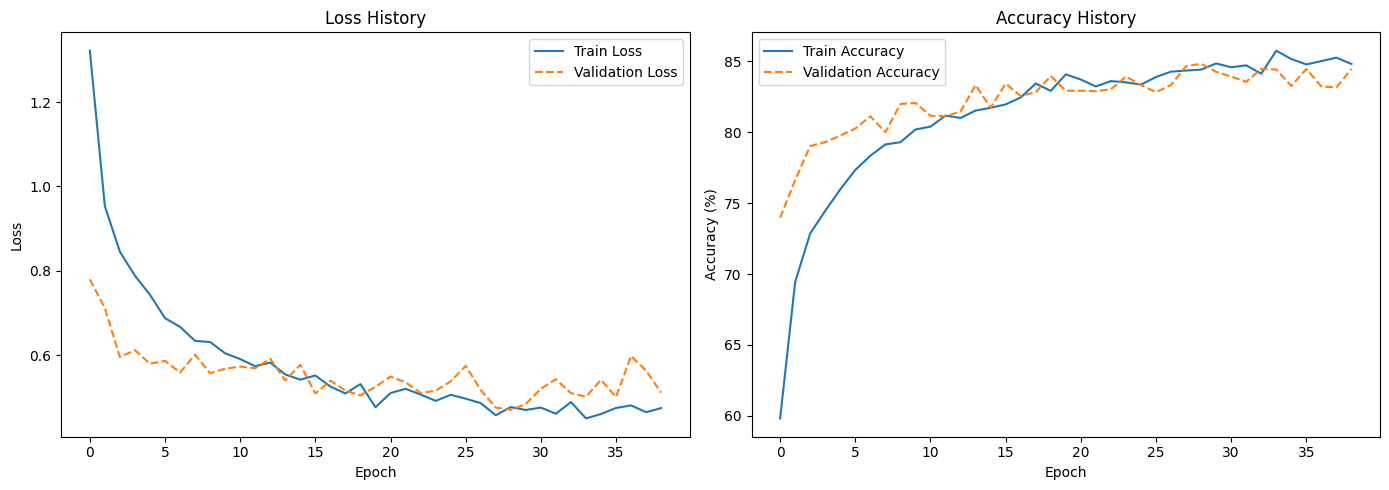

In [30]:
# 1행 2열 subplot 생성
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss 시각화
axes[0].plot(train_loss_history, label='Train Loss')
axes[0].plot(val_loss_history, label='Validation Loss', linestyle='--')
axes[0].set_title('Loss History')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy 시각화
axes[1].plot(train_acc_history, label='Train Accuracy')
axes[1].plot(val_acc_history, label='Validation Accuracy', linestyle='--')
axes[1].set_title('Accuracy History')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

## 4. Test

### 4-1. Test Accuracy

In [33]:
# 체크포인트 불러오기
checkpoint = torch.load("efficientv2_best.pt")

# 모델 가중치 로드
model.load_state_dict(checkpoint['model_state_dict'])  # state_dict만 로드

# 평가
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

<ipython-input-33-85dbf6c139ac>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("efficientv2_best.pt")
Evaluating: 100%|██████████| 188/188 [06:24<0

Test Loss: 0.4950, Test Accuracy: 83.83%


### 4-2. Visualize Model Predictions

In [34]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (12, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

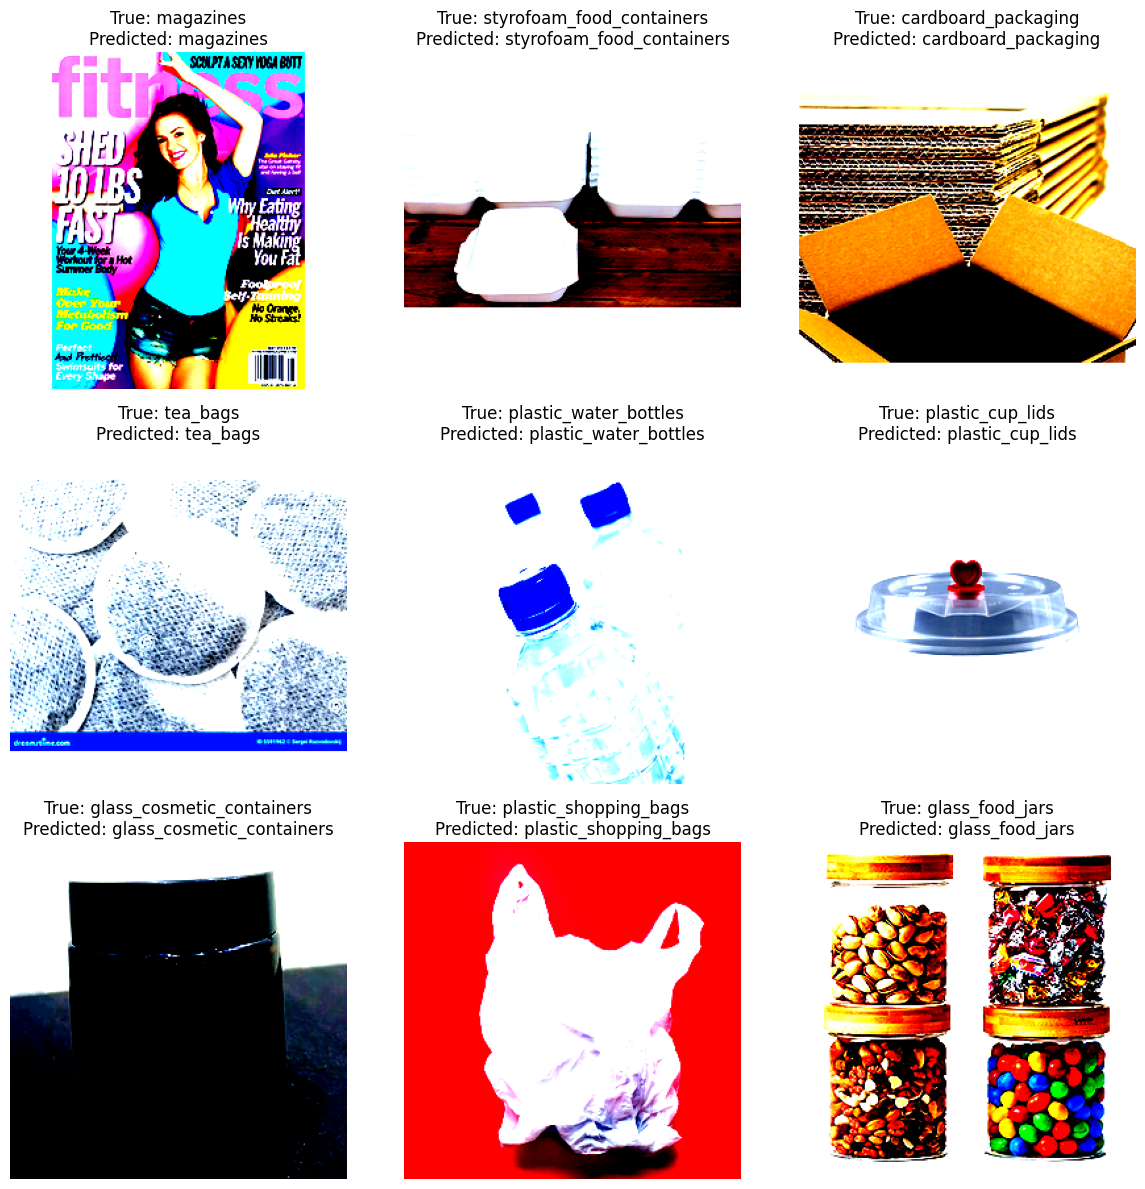

In [39]:
# Perform sample inferences on random test images with different labels
model.eval()
with torch.no_grad():
    indices = list(range(len(test_dataset)))
    random.shuffle(indices)

    selected_images = []
    selected_labels = []
    selected_predicted = []

    for index in indices:
        image, label = test_dataset[index]
        image = image.unsqueeze(0).to('cuda')

        output = model(image)
        _, predicted = torch.max(output, 1)

        if label not in selected_labels:
            selected_images.append(image)
            selected_labels.append(label)
            selected_predicted.append(predicted.item())

        if len(selected_labels) == 9:
            break

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(9):
        axes[i].imshow(selected_images[i].squeeze().cpu().permute(1, 2, 0))
        axes[i].set_title(f"True: {train_dataset.classes[selected_labels[i]]}\nPredicted: {train_dataset.classes[selected_predicted[i]]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

## 5. Inference Time Comparison

Model Type       | @ CPU [ms]   | @ GPU [ms]   |
-----------------|--------------|--------------|
`EfficientNetV2` |     5033     |     1586    |
`EfficientNetV2+Attention`  |   **2536**      |    **315.158**     |

In [41]:
image_path = 'data/images/images/aerosol_cans/real_world/Image_1.png'

input_data = Image.open(image_path)
input_data = valid_transform(input_data).unsqueeze(0).to('cuda')
input_data.shape

NUM_ITERS = 100

In [42]:
import torch.profiler

checkpoint = torch.load("efficientv2_best.pt")
model.load_state_dict(checkpoint['model_state_dict'])

test_model = model.to(device)

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    record_shapes=False,
    profile_memory=False
) as prof:
    with torch.no_grad():
      for _ in range(NUM_ITERS):
        output = test_model(input_data)

print(prof.key_averages().table(sort_by="self_cpu_time_total"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       cudaLaunchKernel        20.55%     521.217ms        20.55%     521.217ms       8.407us       0.000us         0.00%       0.000us       0.000us         62000  
                                aten::cudnn_convolution        19.93%     505.273ms        29.50%     747.948ms      53.425us     132.726ms        42.11%     132.726ms       9.480us         14000  
         

In [3]:
!jupyter nbconvert --to html /content/drive/MyDrive/SWE3052/Efficientnetv2_Attention.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/SWE3052/Efficientnetv2_Attention.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 1548292 bytes to /content/drive/MyDrive/SWE3052/Efficientnetv2_Attention.html
